In [94]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# some colors
mainblue = ["#42719f", "#6ab4ff"]
coralgreen = ["#117a65", "#138D75"]
reddish = ["#c82929", "#e42f2f"]
orangish = ["#d78939", "#e48a2f"]
blueish = ["#4387cb", "#2f89e4"]
import scipy as sc

In [95]:
activations_file = '../../results/fourTag_10x_z_6_epoch_025.pkl'

z = torch.load(activations_file)["activations"]
z = z.numpy()
# Get the number of features
dimension = z.shape[1]
# Determine the grid layout based on the number of features
if dimension <= 4:
    num_rows = 2
    num_cols = 2
elif dimension <= 6:
    num_rows = 2
    num_cols = 3
elif dimension <= 9:
    num_rows = 3
    num_cols = 3 
elif dimension <= 12:
    num_rows = 3
    num_cols = 4
elif dimension <= 16:
    num_rows = 4
    num_cols = 4
else:
    raise ValueError("The number of features is too high to display in a reasonable way.")

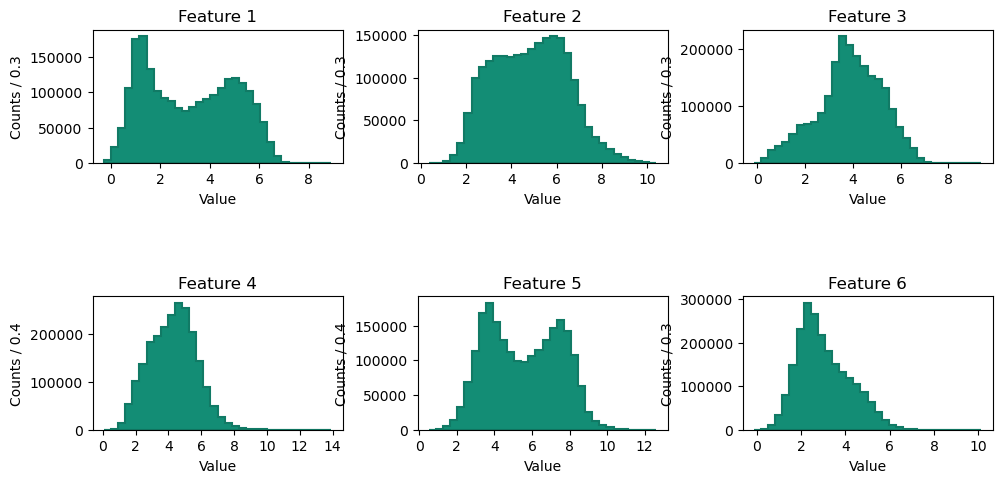

In [67]:
# plots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,5))
#fig.suptitle(f"Histograms of {dimension} Different Features", fontsize=16)
axs = axs.flatten()
h, bins = np.zeros_like(axs), np.zeros_like(axs)

if (dimension < num_rows * num_cols):
    for j in range(1, num_rows*num_cols - dimension + 1):
        axs[-j].axis('off')  # Hide any empty subplots

# Plot histograms for each feature
for i in range(dimension):
    ax = axs[i]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    h[i], bins[i], _ = ax.hist(z[:, i], bins = 32, alpha=1, color='blue', density = False, histtype='stepfilled', linewidth = plt.rcParams["lines.linewidth"], edgecolor = coralgreen[0], facecolor = coralgreen[1])
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel("Value")
    ax.set_ylabel(f"Counts / {(bins[i][1]-bins[i][0]):.1f}")

# layout
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.3, hspace = 1.)

In [96]:
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm

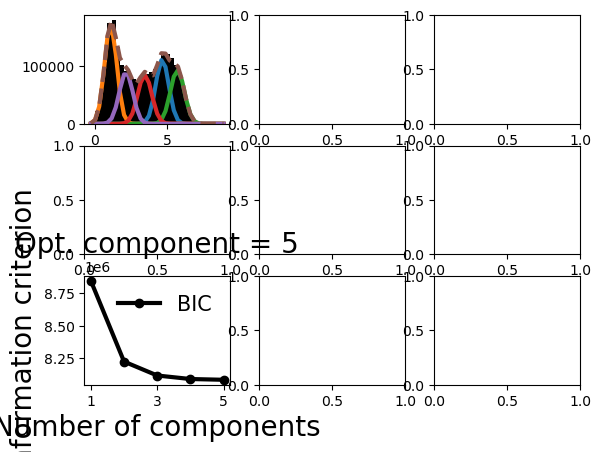

In [159]:
# first of all, let's confirm the optimal number of components
bics = []
min_bic = 0
counter=1
for i in range (5): # test the AIC/BIC metric between 1 and 10 components
  gmm = GMM(n_components = counter, random_state=0, covariance_type = 'full')
  labels = gmm.fit(z[:,0]).predict(z[:,0])
  bic = gmm.bic(z[:,0])
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    n_opt = counter
  counter = counter + 1

fig, axs = plt.subplots(num_rows+1, num_cols)
# plot the evolution of BIC/AIC with the number of components
# Plot 1
axs[-1,0].plot(np.arange(1,6), bics, 'o-', lw=3, c='black', label='BIC')
axs[-1,0].legend(frameon=False, fontsize=15)
axs[-1,0].set_xlabel('Number of components', fontsize=20)
axs[-1,0].set_ylabel('Information criterion', fontsize=20)
axs[-1,0].set_xticks(np.arange(1,6, 2))
axs[-1,0].set_title('Opt. component = '+str(n_opt), fontsize=20)

# create optimal GMM model object
gmm_opt = GMM(n_components = n_opt, random_state=10, covariance_type = 'full')

# find useful parameters
means = gmm_opt.fit(z[:,0]).means_  
covs  = gmm_opt.fit(z[:,0]).covariances_
weights = gmm_opt.fit(z[:,0]).weights_



h, b, _ = axs[0,0].hist(z[:,0], density=False, color='black', bins=32)
# create necessary things to plot

y_axs = []
for i in range(n_opt):
  y_axs.append(np.sum(h*(b[1:]-b[:-1]))*norm.pdf(b, float(means[i][0]), np.sqrt(float(covs[i][0][0])))*weights[i]) # ith gaussian
  axs[0,0].plot(b, y_axs[i], lw=3)
axs[0,0].plot(b, np.sum(y_axs, axis = 0), lw=3, ls='dashed')

(array([0.        , 0.02440021, 0.07320063, 0.14291553, 0.18474446,
        0.18474446, 0.16731574, 0.19171595, 0.18125864, 0.14988708,
        0.16383006, 0.14988695, 0.15685844, 0.19520177, 0.16383006,
        0.15337269, 0.13245824, 0.21263033, 0.1638302 , 0.2265733 ,
        0.10805803, 0.1498872 , 0.12897249, 0.05228615, 0.02091446,
        0.00348574, 0.00348575, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([-0.2770071 ,  0.00987566,  0.29675841,  0.58364117,  0.87052393,
         1.15740669,  1.44428945,  1.7311722 ,  2.01805496,  2.30493784,
         2.59182048,  2.87870312,  3.16558599,  3.45246887,  3.73935151,
         4.02623415,  4.31311703,  4.5999999 ,  4.88688278,  5.17376518,
         5.46064806,  5.74753094,  6.03441334,  6.32129622,  6.60817909,
         6.89506197,  7.18194485,  7.46882725,  7.75571012,  8.042593  ,
         8.3294754 ,  8.61635876,  8.90324116]),
 <BarContainer object of 32 artists>)

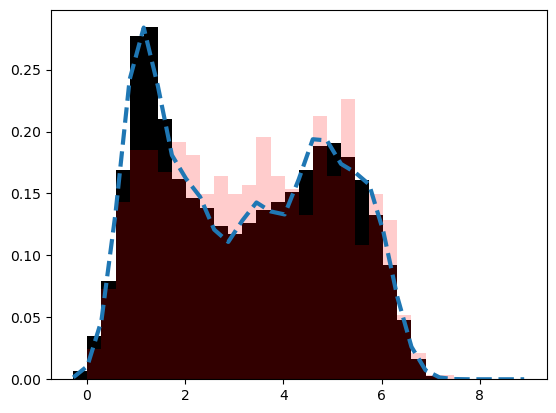

In [218]:
# Sample 1000 random uniform variables 'r' between 0 and 1
r_values = np.random.uniform(0, 1, len(z[:,0]))

weights_cum = np.cumsum(weights)
weights_cum
# Find the indices of the values in weights_cumulative that are immediately higher than 'r'
gaussian_indices = np.searchsorted(weights_cum, r_values[:, np.newaxis], side='right')[:,0]

# Use array indexing to get the parameters for the corresponding Gaussian distributions
mus = [float(means[i][0]) for i in gaussian_indices]
std_devs = [np.sqrt(float(covs[i][0][0])) for i in gaussian_indices]

# Sample from the corresponding Gaussian distributions
sampled_values = np.random.normal(mus, std_devs)

In [219]:
len(sampled_values) == len(z[:,0])

True

(array([3.08500e+03, 1.61030e+04, 5.48300e+04, 1.19474e+05, 1.71901e+05,
        1.68050e+05, 1.30193e+05, 1.06904e+05, 9.82750e+04, 8.49480e+04,
        7.13360e+04, 7.43300e+04, 8.70430e+04, 8.87680e+04, 8.31370e+04,
        9.13990e+04, 1.13140e+05, 1.23991e+05, 1.15873e+05, 1.06921e+05,
        1.03860e+05, 8.90510e+04, 5.87030e+04, 2.81340e+04, 9.51400e+03,
        2.41800e+03, 4.08000e+02, 5.00000e+01, 5.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00]),
 array([-0.2770071 ,  0.00987566,  0.29675841,  0.58364117,  0.87052393,
         1.15740669,  1.44428945,  1.7311722 ,  2.01805496,  2.30493784,
         2.59182048,  2.87870312,  3.16558599,  3.45246887,  3.73935151,
         4.02623415,  4.31311703,  4.5999999 ,  4.88688278,  5.17376518,
         5.46064806,  5.74753094,  6.03441334,  6.32129622,  6.60817909,
         6.89506197,  7.18194485,  7.46882725,  7.75571012,  8.042593  ,
         8.3294754 ,  8.61635876,  8.90324116]),
 <BarContainer object of 32 artists>)

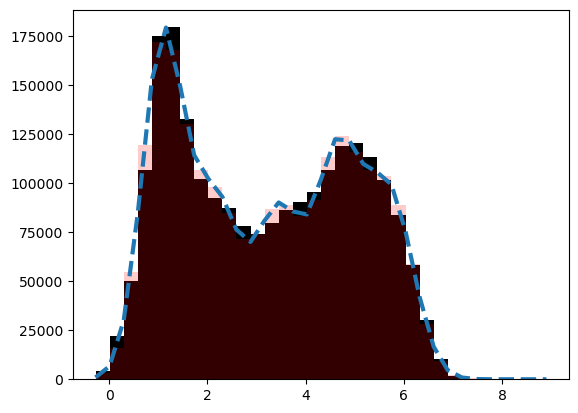

In [220]:
h, b, _ = plt.hist(z[:,0], density=False, color='black', bins=32)
y_axs = []
for i in range(n_opt):
  y_axs.append(np.sum(h*(b[1:]-b[:-1]))*norm.pdf(b, float(means[i][0]), np.sqrt(float(covs[i][0][0])))*weights[i]) # ith gaussian
  axs[0,0].plot(b, y_axs[i], lw=3)
axs[0,0].plot(b, np.sum(y_axs, axis = 0), lw=3, ls='dashed')


plt.plot(b, np.sum(y_axs, axis = 0), lw=3, ls='dashed')
plt.hist(sampled_values, bins = b, color = "red", density = False, alpha = 0.2)